In [1]:
#@title <b><font color="red">▶</font><font color="black"> run this cell and restart runtime</font></b>

!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=5fe6002725349c4d8750e355cfc6effe7d4b35052431669ec0d8a6935254f81d
  Stored in directory: /tmp/pip-ephem-wheel-cache-gt38figl/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.utils import (
    enable_mathjax_in_cell,
)
from tmcourse.node2vec import Node2VecGraph
# from tmcourse.demo import (
# )
# from tmcourse.quiz import (
# )
from tmcourse.ipyquiz import Quiz
from tqdm.notebook import tqdm
!pip install fasttext

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 475 (delta 104), reused 119 (delta 55), pack-reused 307
Receiving objects: 100% (475/475), 40.72 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (287/287), done.
     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3020443 sha256=95c398380db6efbc7d4eccc1f7e081010d94a453b3640750cf0c2db2def167a5
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


<!--@slideshow slide-->
<center><h1>More about word vectors</h1></center>

<!--@slideshow slide-->
# Plan for today
1. GloVe
1. node2vec
1. FastText
1. Word vectors in spaCy
1. Coding session: build news summarizer with word2vec

<!--@slideshow slide-->
# GloVe

<!--@slideshow slide-->
In word2vec, we predict co-occurrence probabilities $\Pr(o|c)$ using dot product of vectors for $o$ and $c$.

<!--@slideshow fragment-->
**Insight**: _ratios_ of co-occurrence probabilities also give information: they encode meaningful componens.

<!--@slideshow slide-->
![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ratios-1.png)

<!--@slideshow slide-->
![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ratios-2.png)

<!--@slideshow slide-->

**Idea**: if we predict
$$
\log\Pr(o|c) = \mathbf{v}_o \cdot \mathbf{v}_c
$$
then _vector differences_ correspond to ratios of co-oocurrence probabilities!
$$
\log\dfrac{\Pr(o|c_2)}{\Pr(o|c_1)} = \mathbf{v}_o \cdot (\mathbf{v}_{c_2} - \mathbf{v}_{c_1})
$$

<!--@slideshow slide-->

So use the following objective function (GloVe):
$$
L(\theta) = \sum_{i \in V, j \in V, i \neq j} f(X_{ij}) \cdot (\mathbf{v}_i \cdot \tilde{\mathbf{v}}_j + b_i + \tilde{b}_j - X_{ij})^2
$$
where 
- $i, j$ -- words
- $X_{ij}$ -- how many times words $i$ and $j$ co-occur
- $\mathbf{v}, \tilde{\mathbf{v}}, b, \tilde{b}$ -- parameters
- $f(X_{ij})$ -- suppress rare (noisy) counters

![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/f.png)

In [2]:
#@slideshow slide tags=remove_input
import gensim.downloader as api

# list all available models
from tabulate import tabulate
from IPython.display import display, HTML
all_gensim_models = api.info()["models"]
gensim_model_description = [(m, all_gensim_models[m]["description"]) for m in all_gensim_models]
display(HTML(tabulate(gensim_model_description, headers=("model name", "description"), tablefmt="html")))

model name,description
fasttext-wiki-news-subwords-300,"1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)."
conceptnet-numberbatch-17-06-300,"ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting."
word2vec-ruscorpora-300,Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
word2vec-google-news-300,Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).
glove-wiki-gigaword-50,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-100,"Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-200,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-wiki-gigaword-300,"Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-25,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)."
glove-twitter-50,"Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)"


<!--@slideshow slide-->
# node2vec



<!--@slideshow slide-->
word2vec algorithm is actually not specific for texts: it is applicable for any _discrete sequences_ (if the total number of elements is finite).

<!--@slideshow fragment-->
Can we apply it for nodes in graphs?
- Find similar nodes.
- Extract features for machine learning.

![alt text](https://snap.stanford.edu/node2vec/homo.png)

<!--@slideshow fragment-->
**Idea**: graph traversal (BFS, DFS, ...) returns a sequence of nodes - what if we apply word2vec?

<!--@slideshow slide-->
node2vec algorithm:
- For each vertex, generate $n$ random walks of length $k$ each
- Parametrize random walks to make it "BFS-like" or "DFS-like".

Example of transition from $t$ to $v$: $x_1$ is the neighbor of $t$, $x_2$ and $x_3$ are not.

![alt text](https://snap.stanford.edu/node2vec/walk.png)

<!--@slideshow slide-->
## Colab demo: find similar GoT characters with node2vec

In [3]:
# read more about the data: https://www.kaggle.com/moradnejad/interaction-networks-for-game-of-thrones-saga
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/got/asoiaf-book5-edges.csv")
df.head()

,Source,Target,Type,weight,book
0,Aegon-I-Targaryen,Daenerys-Targaryen,undirected,4,5
1,Aegon-Targaryen-(son-of-Rhaegar),Daenerys-Targaryen,undirected,11,5
2,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,undirected,4,5
3,Aegon-Targaryen-(son-of-Rhaegar),Franklyn-Flowers,undirected,3,5
4,Aegon-Targaryen-(son-of-Rhaegar),Haldon,undirected,14,5


In [14]:
# create the weighted graph
import networkx as nx
G = nx.Graph()
for i, r in df.iterrows():
    G.add_edge(r["Source"], r["Target"], weight=r["weight"])

# preprocess the graph and generate random walks
node2vec_G = Node2VecGraph(G, p=1, q=0.01)
walks = node2vec_G.simulate_walks(num_walks=30, walk_length=10)
print("Total walks:", len(walks))
from pprint import pprint
pprint(walks[0])

Total walks: 9510
['Yezzan-zo-Qaggaz',
 'Scar',
 'Tyrion-Lannister',
 'Nurse',
 'Yezzan-zo-Qaggaz',
 'Scar',
 'Tyrion-Lannister',
 'Nurse',
 'Yezzan-zo-Qaggaz',
 'Sweets']


In [15]:
# train word2vec on walks
from gensim.models import Word2Vec

gensim_word2vec = Word2Vec(
    sg=1,  # skip-gram
    hs=0,  # negative sampling
    size=200,
    window=3,
    alpha=0.01,
    negative=20
)
gensim_word2vec.build_vocab(walks)
gensim_word2vec.train(walks, total_examples=len(walks), epochs=10)
# find characters similar to Jon Show
pprint(gensim_word2vec.wv.most_similar("Jon-Snow"))

[('Ulmer', 0.9032264947891235),
 ('Alliser-Thorne', 0.8938930034637451),
 ('Tom-Barleycorn', 0.8850666880607605),
 ('Benjen-Stark', 0.865203857421875),
 ('Soren-Shieldbreaker', 0.8634392023086548),
 ('Ygritte', 0.8586257696151733),
 ('Sigorn', 0.8561915755271912),
 ('Torghen-Flint', 0.8504267930984497),
 ('Melisandre', 0.836707592010498),
 ('Brandon-Norrey', 0.8366614580154419)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<!--@slideshow slide-->
# FastText

<!--@slideshow slide-->
## Word vectors with subword information

Sometimes we may guess (at least partially) the meaning of a word by looking at its pieces.


<!--@slideshow fragment-->
For example, for the word "athazagoraphobia" we may guess it is a phobia (a fear of something).

<!--@slideshow fragment-->
(In case you are wondering, "athazagoraphobia" is the fear of being forgotten or ignored and fear of forgetting.)

<!--@slideshow fragment-->
**Idea**: learn not only word vectors, but also subword vectors.

<!--@slideshow slide-->
**Algorithm**:
- Represent each word as a collection of character $n$-gram.
- Include the word w itself in the set of its $n$-grams.
- Add special boundary symbols `<` and `>` at the beginning and end of words, allowing to distinguish prefixes and suffixes from other character sequences.
- Word vector is the sum of the vector representations of its $n$-grams.


<!--@slideshow fragment-->
**Example**: for $n=3$, the word "where" is represented as

  `<wh, whe, her, ere, re>, <where>`
    
> Note that the sequence `<her>`, corresponding to the word "her" is different from the trigram `her` from the word "where".

<!--@slideshow slide-->
## Colab demo: FastText (unsupervised)

In [0]:
import fasttext

In [0]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset="all", shuffle=True, random_state=1, categories=("sci.space",), remove=('headers', 'footers', 'quotes'))

In [0]:
def prepare_text(t):
    import re
    s = " ".join(t.split()).lower()  # lowercase
    return re.sub(r'[^\w\s]',' ',s)  # 

In [0]:
with open("texts.txt", "w") as f:
    for t in dataset.data:
        f.write(prepare_text(t) + "\n")

In [0]:
model = fasttext.train_unsupervised(
    input="texts.txt",
    epoch=10
)

In [26]:
model.get_nearest_neighbors("satellite")

[(0.9310543537139893, 'satellites'),
 (0.826610267162323, 'sat'),
 (0.7046252489089966, 'radar'),
 (0.684397280216217, 'iridium'),
 (0.6659807562828064, 'tracking'),
 (0.6609216928482056, 'telecommunications'),
 (0.6603425145149231, 'korean'),
 (0.656222939491272, 'intelsat'),
 (0.6515015959739685, 'european'),
 (0.6475222706794739, 'japan')]

In [27]:
model.get_nearest_neighbors("satelite")

[(0.965173065662384, 'satellite'),
 (0.8960800766944885, 'satellites'),
 (0.8491849303245544, 'sat'),
 (0.7472147345542908, 'items'),
 (0.7320234775543213, 'korean'),
 (0.723210334777832, 'radar'),
 (0.720881462097168, 'european'),
 (0.7101620435714722, 'iridium'),
 (0.709301233291626, 'olympus'),
 (0.7044820785522461, 'intelsat')]

<!--@slideshow slide-->
## Text classification

**Idea**: 
- Represent a text as the average of word vectors.
- Learn matrix $A$ such that $\mathrm{softmax}(A \cdot v)$ gives probability distribution over classes.
- Instead of the loss function for word2vec (negative log-likelihood), optimize the loss function for classification (cross-entropy).

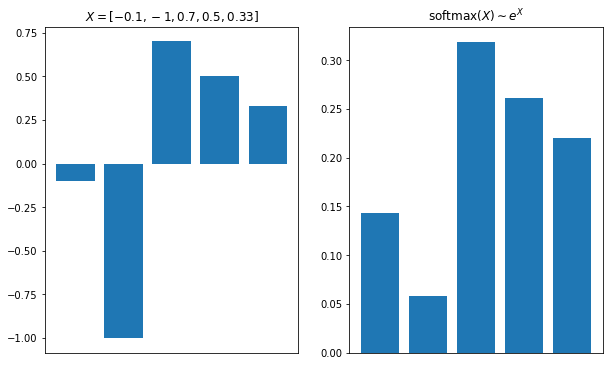

In [28]:
#@slideshow fragment tags=remove_input
import matplotlib.pyplot as plt
from scipy.special import softmax
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

x = [-0.1, -1, 0.7, 0.5, 0.33]
i = list(range(len(x)))
ax1.bar(i, x)
ax2.bar(i, softmax(x))
ax1.set_title(r"$X = {}$".format(x))
ax2.set_title(r"$\mathrm{softmax}(X) \sim e^X$")
ax1.set_xticks([])
ax2.set_xticks([])
plt.show()

<!--@slideshow slide-->
## Colab demo: FastText (supervised)

In [0]:
from sklearn.datasets import fetch_20newsgroups
fetch_params = dict(
    shuffle=True,
    random_state=1,
    remove=('headers', 'footers', 'quotes')
)
train_dataset = fetch_20newsgroups(subset="train", **fetch_params)
test_dataset = fetch_20newsgroups(subset="test", **fetch_params)

In [0]:
def convert_dataset_to_fasttext_file(texts, labels, path):
    with open(path, "w") as f:
        for t, l in zip(texts, labels):
            t = prepare_text(t)
            # labels are stored in file with prefix "__label__"
            f.write(f"__label__{l}\t{t}\n")

convert_dataset_to_fasttext_file(
    train_dataset.data,
    [train_dataset.target_names[c] for c in train_dataset.target],
    "train.txt"
)

In [31]:
# in ipython use % for certain cmds like %cd /path/
!head -n1 train.txt

__label__talk.politics.mideast	well i m not sure about the story nad it did seem biased  what i disagree with is your statement that the u s  media is out to ruin israels reputation  that is rediculous  the u s  media is the most pro israeli media in the world  having lived in europe i realize that incidences such as the one described in the letter have occured  the u s  media as a whole seem to try to ignore them  the u s  is subsidizing israels existance and the europeans are not  at least not to the same degree   so i think that might be a reason they report more clearly on the atrocities  what is a shame is that in austria  daily reports of the inhuman acts commited by israeli soldiers and the blessing received from the government makes some of the holocaust guilt go away  after all  look how the jews are treating other races when they got power  it is unfortunate 


In [0]:
model = fasttext.train_supervised(
    input="train.txt",
    lr=0.1,
    epoch=25
)

In [33]:
total = 0
correct = 0
for t, c in zip(test_dataset.data, test_dataset.target):
    total += 1
    label = test_dataset.target_names[c]
    predicted_label = model.predict(prepare_text(t))[0][0][len("__label__"):]
    if label == predicted_label:
        correct += 1
print(f"accuracy: {correct / total}")

accuracy: 0.5762081784386617


<!--@slideshow slide-->
# Colab demo: word vectors in spaCy

In [0]:
import spacy
# spaCy is equipped by pre-trained word vectors
# for example, they are stored in "en_core_web_lg"
# in Colab, you need to run !python -m spacy download en_core_web_lg (the first cell) and restart runtime
nlp = spacy.load("en_core_web_lg", disable=["tagger", "ner", "parser"])

In [35]:
doc = nlp("dog cat banana afskfsd")

# you can check the attribute `.has_vector` of a token
for token in doc:
    print(f"Token '{token.text}' has vector: {token.has_vector}")

# doc (parsed text, the collection of tokens) also has vector (the average over all tokens)
print(f"Doc has vector: {doc.has_vector}")

Token 'dog' has vector: True
Token 'cat' has vector: True
Token 'banana' has vector: True
Token 'afskfsd' has vector: False
Doc has vector: True


In [38]:
# for any pair of objects that have vectors, we can find similarity
# the example from the last lesson
doc1 = nlp("How can I be a good geologist?")
doc2 = nlp("What should I do to be a great geologist?")
doc3 = nlp("What should I do to be a good geologist?")
doc1.similarity(doc2), doc1.similarity(doc3)

(0.9807831604694341, 0.9820952641696503)

In [0]:
# in particular, any subsequence of a document (so-called Span) also may have a vector
# for example, a sentence in a document has vector (the average over all tokens of the sentence)
# to split the document into sentences, we need to add 'sentencizer' to NLP pipeline
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [40]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(
    subset="all",
    shuffle=True,
    random_state=1,
    categories=("sci.space",),
    remove=('headers', 'footers', 'quotes')
)
from pprint import pprint

# after the sentenciser has been added, the parsed document contains `.sents` attribute:
for sentence in nlp(dataset.data[0]).sents:
    print("SENTENCE:\n", sentence)
    print("HAS VECTOR:", sentence.has_vector)
    print("---")

SENTENCE:
 Re: Space billboards

Even easier to implement than writing messages on the Moon, once upon
a time a group of space activists I belonged to in Seattle considered
a "Goodyear Blimp in orbit".
HAS VECTOR: True
---
SENTENCE:
  The idea was to use a large structure
that could carry an array of lights like the Goodyear Blimp has.
HAS VECTOR: True
---
SENTENCE:
 
Placed in a low Earth orbit of high inclination, it could eventually
be seen by almost everyone on Earth.
HAS VECTOR: True
---
SENTENCE:
  Only our collective disapproval
of cluttering up space with such a thing stopped us from pursuing
it.
HAS VECTOR: True
---
SENTENCE:
  It had quite feasible economics, which I will not post here
because I don't want to encourage the idea (if you want to do such
a thing, go figure it out for yourself).
HAS VECTOR: True
---
SENTENCE:
 

Dani Eder

HAS VECTOR: True
---


<!--@slideshow slide-->
# Coding session

Build news summarizer using word2vec.

Try the following idea:
1. Assume that there is a "central" vector (the main idea) of the article which is the average vector of all tokens in the article.
1. Find $k$ sentences closest to the "central" vector. The assumption is that these sentences are "informative", and other sentences are "noisy" and not important.

The function `parse_techcrunch_url(url)` parses the content from [techcrunch.com](https://techcrunch.com), you can use it to check your implementation on real data.

Also, implement a random baseline (get $k$ random sentences from the text) and compare the results.

In [15]:
def parse_techcrunch_url(url):
    import bs4
    import re
    import requests
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    items = soup.find("div", {"class": "article-content"}).findAll("p")
    raw_html = "\n".join(map(str, items))
    cleanr = re.compile('<.*?>')
    clean_html = re.sub(cleanr, '', raw_html)
    return clean_html

from pprint import pprint
url = "https://techcrunch.com/2020/05/23/hackers-iphone-new-jailbreak/"
parsed_url = parse_techcrunch_url(url)
print(type(parsed_url))
# pprint(parsed_url)

<class 'str'>


In [0]:
def summarize_text(text, k: int):
    # YOUR CODE HERE
  import spacy, operator

  nlp = spacy.load("en_core_web_lg", disable=["tagger", "ner", "parser"])
  nlp.add_pipe(nlp.create_pipe("sentencizer"))
  doc = nlp(text)
  vec_rankings = []
  i = 0
  for sentence in doc.sents:
    sent_rank = doc.similarity(sentence)
    vec_rankings.append((i, sent_rank, sentence))
    i += 1
  return sorted(vec_rankings, key=operator.itemgetter(1, 0), reverse=True)[:k]

In [28]:
pprint(summarize_text(parsed_url, 2)) 

[(1,
  0.9795232646837688,
  
For as long as Apple  has kept up its “walled garden” approach to iPhones by only allowing apps and customizations that it approves, hackers have tried to break free from what they call the “jail,” hence the name “jailbreak.”),
 (6,
  0.9744662879431004,
  
Details of the vulnerability that the hackers used to build the jailbreak aren’t known, but it’s not expected to last forever.)]


<!--@slideshow slide-->
# Recommended resources
- [node2vec](https://snap.stanford.edu/node2vec/)
- FastText
  - [Documentation](https://fasttext.cc/)
  - [Paper "Enriching Word Vectors with Subword Information"](https://arxiv.org/abs/1607.04606)
  - [Paper "Bag of Tricks for Efficient Text Classification"](https://arxiv.org/abs/1607.01759)
- [vectors in spaCy](https://spacy.io/usage/vectors-similarity)